# Librairies

In [1]:
import zipfile as zp

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 as cv

import os
from os import listdir
from os.path import isfile, join

import plotly.express as px

import pathlib

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten,MaxPool2D 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

from natsort import natsorted

from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics

# Useful Functions

In [2]:
#Function to dezip file
def import_data(path_directory):
  var_zip = zp.ZipFile(path_directory, 'r')
  var_zip.extractall('/content')
  var_zip.close()

#Function that allowed us to create image data
def load_images(folder):
  data_img = []
  onlyfiles = [f for f in listdir(folder) if isfile(join(folder, f))]
  onlyfiles = sorted(onlyfiles)
  print(len(onlyfiles))
  for i in onlyfiles:
    img = cv.imread(os.path.join(folder, i))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    if img is not None:
      data_img.append(img)
  return data_img

#Function to print n ramdom images from one of the folders
def show_images(data, n):
  plt.figure(figsize=(20,20))
  for i in range(n):
    a = random.randint(0, len(data))
    ax=plt.subplot(1,n,i+1)
    ax.title.set_text(a)
    plt.imshow(data[a])

#Function to plot Accurary and Loss
def show_accuracy_loss(history_model):
  acc = history_model.history['accuracy']
  val_acc = history_model.history['val_accuracy']

  loss = history_model.history['loss']
  val_loss = history_model.history['val_loss']

  epochs_range = range(1, len(acc) + 1)

  plt.figure(figsize=(8, 8))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

#Function to compute Accurary and Loss on new data
def compute_acc_loss(model, data):
  loss, accuracy = model.evaluate(data)
  print("initial loss: {:.2f}".format(loss))
  print("initial accuracy: {:.2f}".format(accuracy))

#Create Confusion Matrix
def create_confusion_matrix(model, data, prediction_true):
  prediction = model.predict(data)
  predicted_classe = np.argmax(prediction, axis=1)
  return metrics.confusion_matrix(y_true=prediction_true, y_pred=predicted_classe) 
  
#Function to compute HTER
def compute_Hter(confusion_matrix):
  FP = confusion_matrix[1][0] 
  FN = confusion_matrix[0][1]
  TP = confusion_matrix[1][1]
  TN = confusion_matrix[0][0]

  # Fall out or false positive rate
  FPR = (FP/(FP+TN))*100
  # False negative rate
  FNR = (FN/(TP+FN))*100
  # HTER
  HTER = (FPR + FNR)/2

  print("FP = {}  FN = {}  TP = {}  TN = {}".format(FP, FN, TP, TN))
  print("FPR = {}%  FNR = {}%  HTER = {}%".format(FPR, FNR, HTER))

#Function to predict
def predict_function(model, folder_images, fileName):
  image_predict = load_images(folder_images)
  X = np.array(image_predict)
  y_pred = model.predict(X)

  if not os.path.exists(fileName):
    print("Creating {} file".format(str(fileName)))
    print('---------------------------------------------------------------------')
    with open(fileName, 'w') as f:
      for i in range(len(image_predict)):
          a = np.argmax(y_pred[i])
          f.write("%s\n" % str(a))
    print("Finish {}".format(str(fileName)))
  else:
    print("{} exist. \nYou should change name".format(str(fileName)))

# Data Exploration

- **Import Files**

In [3]:
import_data('/content/drive/MyDrive/Data/nov2021_train.zip')
import_data('/content/drive/MyDrive/Data/nov2021_val.zip')
!cp /content/drive/MyDrive/Data/label_nov2021_train.txt /content

In [4]:
train_path = '/content/nov2021_train'
test_path = '/content/nov2021_val'
label_train_path ='/content/label_nov2021_train.txt'

- **Load and Show images**

In [5]:
train_images = load_images(train_path)
test_images = load_images(test_path)

119294
19878


Train Images


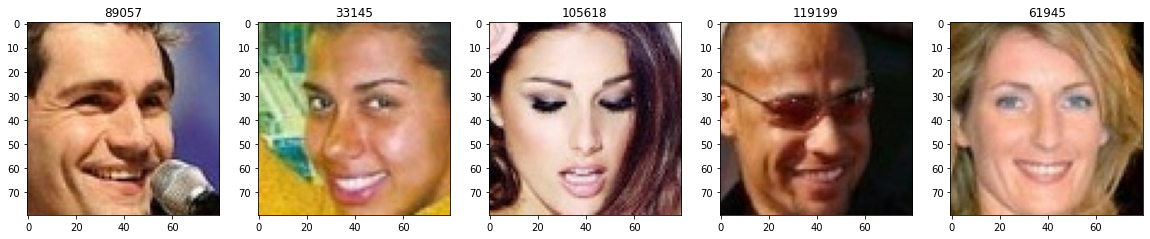

In [6]:
print("Train Images")
show_images(train_images,5)

Test Images


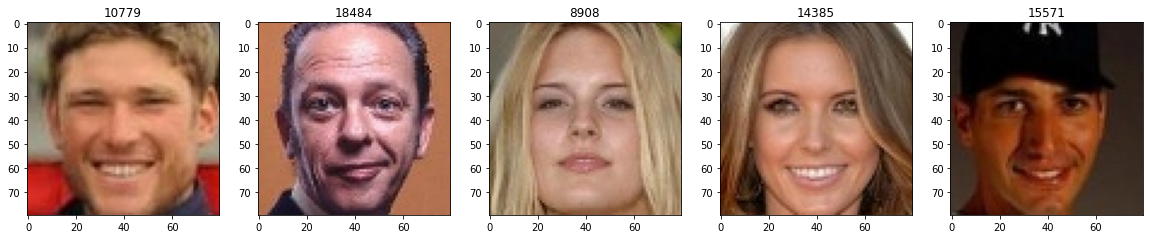

In [7]:
print("Test Images")
show_images(test_images,5)

- **Create DataFrame**

In [8]:
train_label = np.loadtxt(label_train_path)

In [9]:
data = {'Images': train_images,
        'Labels': train_label}

df = pd.DataFrame(data)

In [10]:
df["Labels"] = df["Labels"].astype(int)

In [11]:
df.head()

,Images,Labels
0,"[[[120, 155, 161], [117, 148, 153], [113, 134,...",1
1,"[[[27, 4, 12], [32, 9, 17], [47, 24, 32], [54,...",1
2,"[[[13, 14, 6], [15, 16, 8], [12, 13, 7], [9, 1...",0
3,"[[[79, 48, 19], [96, 65, 36], [113, 82, 53], [...",0
4,"[[[69, 0, 3], [59, 0, 0], [129, 54, 48], [209,...",0


## Data Analyse

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119294 entries, 0 to 119293
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   Images  119294 non-null  object
 1   Labels  119294 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB


In [13]:
plot_Labels = df['Labels']

dataframe = pd.DataFrame({'Labels' : plot_Labels})
fig = px.histogram(dataframe, x="Labels", color="Labels")
fig.show()

On remaque que notre dataset comporte plus de label 1 que de label 0, ce qui se traduit par un déséquilibre entre les deux labels.

# Create Model & Test

In [14]:
files = natsorted(os.listdir(train_path))

In [15]:
data = {'Images': files,
        'Labels': train_label}

df = pd.DataFrame(data)

In [16]:
df["Labels"] = df["Labels"].astype(int)
df["Labels"] = df["Labels"].astype(str)

In [17]:
df.head()

,Images,Labels
0,000000.jpg,1
1,000001.jpg,1
2,000002.jpg,0
3,000003.jpg,0
4,000004.jpg,0


In [18]:
X_train, X_test, y_train,y_test = train_test_split(df['Images'], df['Labels'], test_size=0.2, random_state=42)

In [19]:
train_dir = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_pred_true = train_dir['Labels'].values.tolist()

In [20]:
validation_dir = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
val_pred_true = validation_dir['Labels'].values.tolist()

In [21]:
batch_size = 32
img_height = 80
img_width = 80
epochs=20

In [22]:
train_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=train_dir,
    directory=train_path,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    class_mode="sparse",
    target_size=(img_height,img_width))

validation_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=validation_dir,
    directory=train_path,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    class_mode="sparse",
    target_size=(img_height,img_width))

Found 95435 validated image filenames belonging to 2 classes.
Found 23859 validated image filenames belonging to 2 classes.


In [23]:
val_pred_true = [int(i) for i in val_pred_true]

## Model_1

In [24]:
model_1 = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs
)

Epoch 1/20
2983/2983 [==============================] - 95s 27ms/step - loss: 0.3850 - accuracy: 0.8136 - val_loss: 0.3265 - val_accuracy: 0.8469
Epoch 2/20
2983/2983 [==============================] - 81s 27ms/step - loss: 0.3053 - accuracy: 0.8599 - val_loss: 0.3041 - val_accuracy: 0.8638
Epoch 3/20
2983/2983 [==============================] - 81s 27ms/step - loss: 0.2814 - accuracy: 0.8735 - val_loss: 0.2934 - val_accuracy: 0.8679
Epoch 4/20
 104/2983 [>.............................] - ETA: 1:07 - loss: 0.2511 - accuracy: 0.8867

In [ ]:
show_accuracy_loss(history_1)

In [ ]:
compute_acc_loss(model_1, validation_generator)

- **Overfitting**

In [ ]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True)

In [ ]:
# New Train Dataset
train_generator = datagen.flow_from_dataframe(
    dataframe=train_dir,
    directory=train_path,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    class_mode="sparse",
    target_size=(img_height,img_width))

In [ ]:
# New Model
model_1 = Sequential([
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(2)
])

model_1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history_1 = model_1.fit(
  train_generator,
  validation_data=validation_generator,
  epochs=epochs
)

In [ ]:
show_accuracy_loss(history_1)

In [ ]:
compute_acc_loss(model_1, validation_generator)

In [ ]:
cM_1 = create_confusion_matrix(model_1, validation_generator, val_pred_true)
compute_Hter(cM_1)

In [ ]:
model_1.save('models_1_ASSOUMA_ZEIDAN.h5')

In [ ]:
fileName = '/content/predictions_1_ASSOUMA_ZEIDAN.txt'
predict_function(model_1, test_path, fileName)

## Model_2

- **Dataset balancing**

In [ ]:
data2 = {'Images': files,
        'Labels': train_label}

df2 = pd.DataFrame(data2)

In [ ]:
df2["Labels"] = df2["Labels"].astype(int)
df2["Labels"] = df2["Labels"].astype(str)

In [ ]:
label0 = df2[df2['Labels'] == "0"]
label1 = df2[df2['Labels'] == "1"]
label1 = label1.sample(n=label0.shape[0], random_state=42)

In [ ]:
df2 = pd.concat([label0, label1])

In [ ]:
plot_Labels = df2['Labels']

dataframe = pd.DataFrame({'Labels' : plot_Labels})
fig = px.histogram(dataframe, x="Labels", color="Labels")
fig.show()

On fait de l'undersampling pour rééquilibrer notre dataset.

In [ ]:
X_train, X_test, y_train,y_test = train_test_split(df2['Images'], df2['Labels'], test_size=0.2, random_state=42)

In [ ]:
train_dir = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
train_pred_true = train_dir['Labels'].values.tolist()

In [ ]:
validation_dir = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
val_pred_true = validation_dir['Labels'].values.tolist()

In [ ]:
val_pred_true = [int(i) for i in val_pred_true]

In [ ]:
train_generator = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True).flow_from_dataframe(
        dataframe=train_dir,
        directory=train_path,
        x_col="Images",
        y_col="Labels",
        batch_size=batch_size,
        shuffle=True,
        class_mode="sparse",
        target_size=(img_height,img_width))

validation_generator = ImageDataGenerator().flow_from_dataframe(
    dataframe=validation_dir,
    directory=train_path,
    x_col="Images",
    y_col="Labels",
    batch_size=batch_size,
    shuffle=True,
    class_mode="sparse",
    target_size=(img_height,img_width))

In [ ]:
model_2 = Sequential([
  layers.Rescaling(1./255, input_shape=(80, 80, 3)),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(64, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(2, activation='softmax'),
])

model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
Mycallback = [
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, restore_best_weights=True),
              tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1)]

In [ ]:
history_2 = model_2.fit(train_generator, validation_data = validation_generator, epochs=epochs, callbacks=Mycallback)

In [ ]:
show_accuracy_loss(history_2)

In [ ]:
compute_acc_loss(model_2, validation_generator)

In [ ]:
cM_2 = create_confusion_matrix(model_2, validation_generator, val_pred_true)
compute_Hter(cM_2)

In [ ]:
model_2.save('models_2_ASSOUMA_ZEIDAN.h5')

In [ ]:
fileName = '/content/predictions_2_ASSOUMA_ZEIDAN.txt'
predict_function(model_2, test_path, fileName)

# Understand Model

In [ ]:
def display_image_filtered(model,layer_name,image):
    inp= model.inputs 
    out1= model.get_layer(layer_name).output  
    feature_map_1= Model(inputs= inp, outputs= out1)
    img = cv.imread(image)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)             
    input_img= np.expand_dims(img, axis=0)      
    f=feature_map_1.predict(input_img) 
    dim = f.shape[3]
    print(f'{layer_name} | Features Shape: {f.shape}')
    print(f'Dimension {dim}')
    fig= plt.figure(figsize=(30,30))      
    for i in range(dim):
        ax = fig.add_subplot(dim/2,dim/2,i+1)
        ax.axis('off')
        ax.imshow(f[0,:,:,i])

def display_image(img):
  num = 6
  for i in range(0,3):
      if num == 0 and i==0:
          print('-----------------------------------------------------')
          print(f'{i+1}st convolutionnal layer')
          display_image_filtered(model_2,f'Conv2d',img)
          print('--------')
          print(f'{i-1}nd Pooling')
          display_image_filtered(model_2,f'MaxPooling2D ',img)
          print('-----------------------------------------------------')
      else:
          print('-----------------------------------------------------')
          print(f'{i+1}st convolutionnal layer')
          display_image_filtered(model_2,f'conv2d_{num+i}',img)
          print('--------')
          print(f'{i+1}nd Pooling')
          display_image_filtered(model_2,f'max_pooling2d_{num+i}',img)
          print('-----------------------------------------------------')

In [ ]:
img_1='/content/nov2021_train/000000.jpg'
img_2='/content/nov2021_val/000000.jpg'
img_3='/content/nov2021_val/000001.jpg'
img_4='/content/nov2021_train/000406.jpg'
img_5='/content/nov2021_train/000004.jpg'
img_6='/content/nov2021_train/100941.jpg'

In [ ]:
display_image(img_1)

In [ ]:
display_image(img_2)

In [ ]:
display_image(img_3)

In [ ]:
display_image(img_4)

In [ ]:
display_image(img_5)

In [ ]:
display_image(img_6)

In [ ]:
def display_filter(model, layer_name):
    layer = model.get_layer(layer_name)
    filter, bias= layer.get_weights()
    dim = filter.shape[3]
    print(f'{layer_name} | Filter Shape: {filter.shape} Bias Shape: {bias.shape}')
    print(f'Dimension {dim}')
    f_min, f_max = filter.min(), filter.max()
    filter = (filter - f_min) / (f_max - f_min)
    print(filter.shape)
    fig= plt.figure(figsize=(30,30))
    for i in range(dim):
        ax = fig.add_subplot(dim/2,dim/2,i+1)
        ax.axis('off')
        try:
            ax.imshow(filter[:,:,:,i])
        except:
            ax.imshow(filter[:,:,:,i][0])
          
display_filter(model_2,f'conv2d_{num}')